In [14]:
import os

import torch
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.ch_tokenizer import CharTokenizer

from models.encoder_only.enc_only_transformer import EncoderOnlyTransformer
from models.decoder_only.dec_only_transformer import DecoderOnlyTransformer

import config_encoder_only as cfg_enc
import config_decoder_only as cfg_dec
import config_lstm as cfg_lstm

import importlib
importlib.reload(cfg_enc)
importlib.reload(cfg_dec)
importlib.reload(cfg_lstm)

<module 'config_lstm' from '/home/ros/repos/Mini_Transfomer_Project/config_lstm.py'>

Function to plot attention weights in a transformer

In [15]:
def plot_attention_layer(attn_weights, tokens):

    num_layers = len(attn_weights)
    num_heads = attn_weights[0].size(1)
    
    fig, axs = plt.subplots(num_layers, num_heads, figsize=(3*num_heads, 3*num_layers))
    fig.suptitle("Attention Maps per Layer and Head", fontsize=16)
    
    for layer_idx, attn_tensor in enumerate(attn_weights):
        attn_tensor = attn_tensor.squeeze(0).cpu()
        
        for head_idx in range(num_heads):
            ax = axs[layer_idx, head_idx] if num_layers > 1 else axs[head_idx]
            sns.heatmap(attn_tensor[head_idx], xticklabels=tokens, yticklabels=tokens,
                        cmap="viridis", ax=ax, cbar=False)
            ax.set_title(f"L{layer_idx+1} H{head_idx+1}")
            ax.tick_params(axis='x', labelrotation=90)
            ax.set_xlabel("Key")
            ax.set_ylabel("Query")
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Functions to plot training loss, validation loss and perplexity over epochs

In [16]:
def plot_train_val_losses(training_info_path):
    
    epochs = []
    train_loss = []
    val_loss = []

    with open(training_info_path, 'r') as file:
        next(file)
        for line in file:
            content = line.strip().split(',')
            epochs.append(int(content[0]))
            train_loss.append(round(float(content[1]), 3))
            val_loss.append(round(float(content[2]), 3))

    plt.figure(figsize=(8, 3))
    plt.title('Training Loss and Validation Loss')
    plt.plot(epochs, train_loss, marker='o', label='Training Loss')
    plt.plot(epochs, val_loss, marker='x', label='Validation_Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(epochs)
    plt.grid(True)
    plt.show()

In [17]:
def plot_losses(training_info_path):
    
    epochs = []
    train_loss = []
    val_loss = []
    perplexity = []

    with open(training_info_path, 'r') as file:
        next(file)
        for line in file:
            content = line.strip().split(',')
            epochs.append(int(content[0]))
            train_loss.append(round(float(content[1]), 3))
            val_loss.append(round(float(content[2]), 3))
            perplexity.append(round(float(content[3]), 3))

    plt.figure(figsize=(10, 12))
    plt.suptitle('Training Loss, Validation Loss and Perplexity')

    plt.subplot(3, 1, 1)
    plt.plot(epochs, train_loss, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.xticks(epochs)
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(epochs, val_loss, marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.xticks(epochs)
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(epochs, perplexity, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.xticks(epochs)
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

LSTM: Visualize Training Loss, Validation Loss and Perplexity over the Epochs

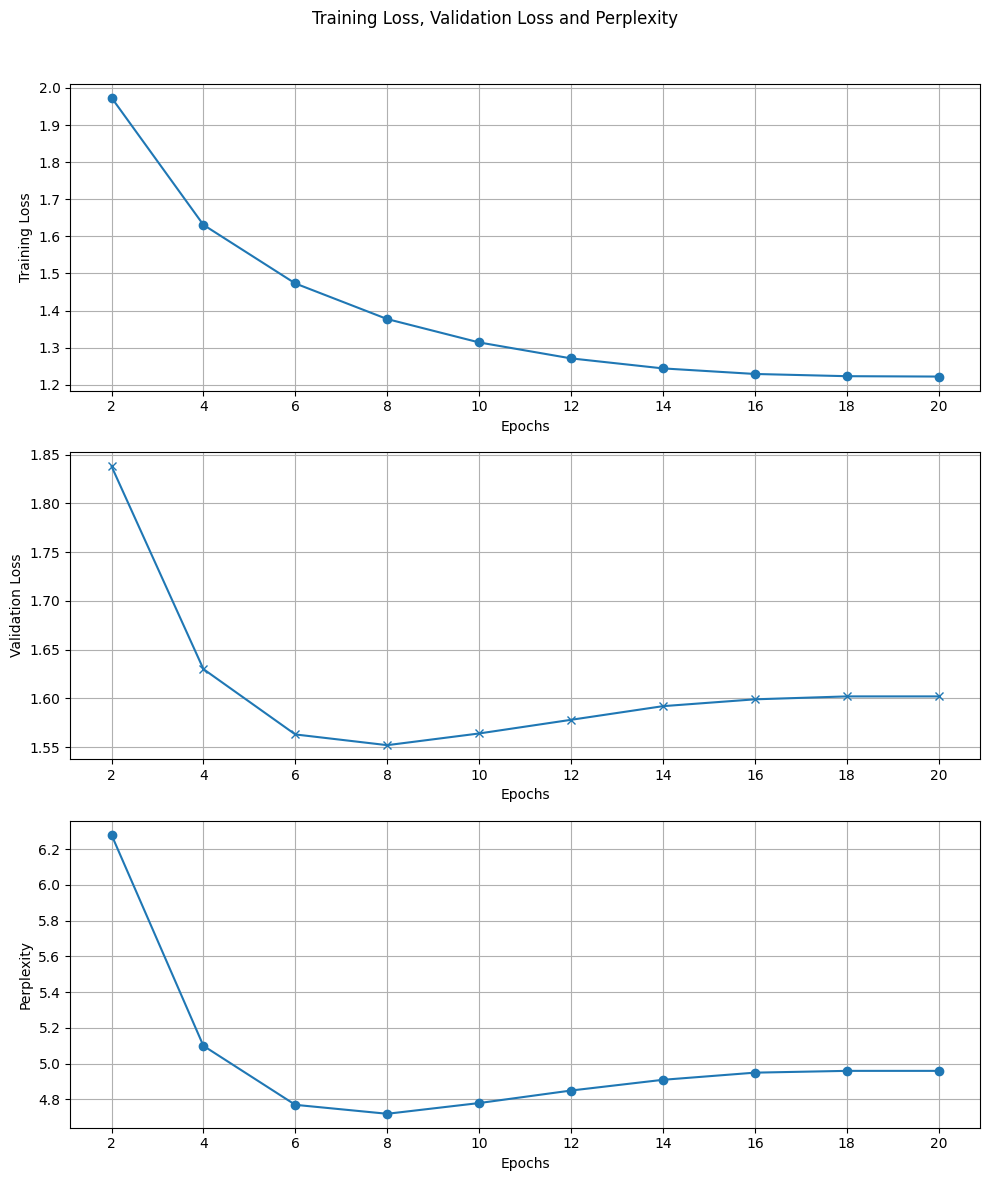

In [18]:
training_info_path = "training_experiments/lstm/ep20_b64_lr5e-05_dataset_alice_in_wonderland.txt_token_ch/training_info.txt"
plot_losses(training_info_path)

Encoder-only Transformer: Visualize Training Loss, Validation Loss and Perplexity over the Epochs, and Attention-Weights as heatmaps

In [ ]:


checkpoint_path = cfg_enc.CHECKPOINT_PATH
txt_file_path = cfg_enc.TXT_FILE_PATH

tokenizer = CharTokenizer(txt_file_path)
vocab_size = tokenizer.vocab_size

seq_len = cfg_enc.SEQ_LEN
embed_dim = cfg_enc.MODEL_CONFIG['embed_dim']
num_heads = cfg_enc.MODEL_CONFIG['num_heads']
hidden_dim = cfg_enc.MODEL_CONFIG['hidden_dim']
enc_ffn_h_dim = cfg_enc.MODEL_CONFIG['enc_ffn_h_dim']
num_enc = cfg_enc.MODEL_CONFIG['num_enc']
use_sinusoidal = cfg_enc.MODEL_CONFIG['use_sinusoidal']

device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = EncoderOnlyTransformer(vocab_size, embed_dim, seq_len, hidden_dim, num_heads, enc_ffn_h_dim, num_enc, use_sinusoidal).to(device)

model.load_state_dict(torch.load(checkpoint_path))

In [ ]:
training_info_path = os.path.relpath(os.path.join(os.path.dirname(checkpoint_path), 'training_info.txt'))

plot_losses(training_info_path)

In [ ]:
model.eval()

seed_text = "Alice and her sister"
input_tokens = tokenizer.encode(seed_text)

if len(input_tokens) > seq_len:
    input_tokens = torch.tensor(input_tokens[-seq_len:]).unsqueeze(0).to(device)
else:    
    input_tokens = torch.tensor(input_tokens).unsqueeze(0).to(device)

with torch.no_grad():
        pred_logits, attention_weights = model(input_tokens)

        tokens = tokenizer.decode(input_tokens[0].tolist())

        plot_attention_layer(attention_weights, tokens)

Decoder-only Transformer: Visualize Training Loss, Validation Loss and Perplexity over the Epochs, and Attention-Weights as heatmaps

In [ ]:
checkpoint_path = cfg_dec.CHECKPOINT_PATH
txt_file_path = cfg_dec.TXT_FILE_PATH

tokenizer = CharTokenizer(txt_file_path)
vocab_size = tokenizer.vocab_size

seq_len = cfg_dec.SEQ_LEN
embed_dim = cfg_dec.MODEL_CONFIG['embed_dim']
num_heads = cfg_dec.MODEL_CONFIG['num_heads']
hidden_dim = cfg_dec.MODEL_CONFIG['hidden_dim']
dec_ffn_h_dim = cfg_dec.MODEL_CONFIG['dec_ffn_h_dim']
num_dec = cfg_dec.MODEL_CONFIG['num_dec']
use_sinusoidal = cfg_dec.MODEL_CONFIG['use_sinusoidal']

device = ('cuda' if torch.cuda.is_available() else 'cpu')

model = DecoderOnlyTransformer(vocab_size, embed_dim, seq_len, hidden_dim, num_heads, dec_ffn_h_dim, num_dec, use_sinusoidal).to(device)

model.load_state_dict(torch.load(checkpoint_path))

In [ ]:
training_info_path = os.path.relpath(os.path.join(os.path.dirname(checkpoint_path), 'training_info.txt'))

plot_losses(training_info_path)

In [ ]:
model.eval()

seed_text = "He who shan't be named"
input_tokens = tokenizer.encode(seed_text)

if len(input_tokens) > seq_len:
    input_tokens = torch.tensor(input_tokens[-seq_len:]).unsqueeze(0).to(device)
else:    
    input_tokens = torch.tensor(input_tokens).unsqueeze(0).to(device)

with torch.no_grad():
        pred_logits, attention_weights = model(input_tokens)

        tokens = tokenizer.decode(input_tokens[0].tolist())

        plot_attention_layer(attention_weights, tokens)